# Learning to Learn w\ Quantum NN via Classical NN

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/stfnmangini/QOSF-Mentorship/blob/main/l2l_0.ipynb)

This it the first jupyter notebook used to familiarize with _Pennylane_ and _RNNs_ and _LSTMs_.

At first, the QAOA example for MAXCUT will be implemented.

**Run cell below only if using this notebook in Colab**  
Installing required dependencies and packages

In [ ]:
IS_COLAB = False
if IS_COLAB:
    !pip install --upgrade qiskit
    !pip install --upgrade pennylane
    !pip install networkx

#### Importation of required packages

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qaoa

import tensorflow as tf

import networkx as nx
import matplotlib.pyplot as plt

#from tqdm.notebook import tqdm

Set the seed for reproducibility of results

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

## Generation of data: graphs

Generation of a rangom graph $G_{n,p}$ where:
- $n$ is the number of nodes in the graphs
- $p$ is the probability of creation of an edge between two nodes

In [3]:
def generate_graphs(n_graphs, n_nodes, p_edge):
    datapoints = []
    for _ in range(n_graphs):
        random_graph = nx.gnp_random_graph(n_nodes, p = p_edge)
        datapoints.append(random_graph)
    return datapoints

Sample of a generted graph with 7 nodes and 11 edges (p=0.43)


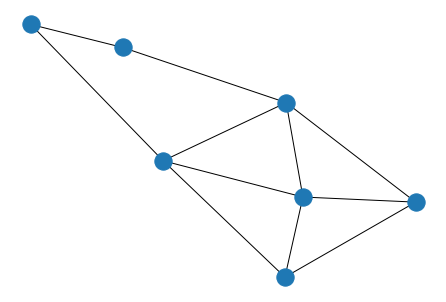

In [4]:
# Define parameters of the graph
n_graphs = 10
n_nodes = 7
p_edge = 3./n_nodes
graphs = generate_graphs(n_graphs, n_nodes, p_edge)

print(f"Sample of a generted graph with {len(graphs[0].nodes)} nodes and {len(graphs[0].edges)} edges (p={p_edge:.2f})")
nx.draw(graphs[0])

## Creating QAOA circuit

In [5]:
def qaoa_from_graph(graph):
    """
    Creates a QAOA circuit instance of the MaxCut problem given a graph. Has nested function definitions needed for
    the creation of the circuit. When called, it instantiate a the structure of the circuit given the input graph,
    and outputs a function which needs only the parameters to be evaluated. 
    
    Args
    ------
    graph: Graph coming generated with networkx.
    
    Return
    ------
    hamiltonian: A function which, given params as input, evaluates the cost function of the 
                 QAOA qautntum circuit.
    
    """
        
    # Number of qubits (wires) equal to the number of nodes in the graph
    wires = range(len(graph.nodes))
    
    # Define the structure of the cost and mixer subcircuits
    cost_h, mixer_h = qaoa.maxcut(graph)   
    
    # Defines a layer of the QAOA ansatz from the cost and mixer Hamiltonians
    def qaoa_layer(gamma, alpha):
        qaoa.cost_layer(gamma, cost_h)
        qaoa.mixer_layer(alpha, mixer_h)
       
    # Creates the actual quantum circuit for the QAOA algorithm
    def circuit(params, **kwargs): 
        for w in wires:
            qml.Hadamard(wires=w)
        qml.layer(qaoa_layer, 2, params[0], params[1])
     
    # Evaluates the cost function
    def hamiltonian(params, **kwargs):
        dev = qml.device('default.qubit.tf', wires=len(graph.nodes))
        cost = qml.ExpvalCost(circuit, cost_h, dev, interface="tf",  diff_method = "backprop")
        return cost(params)
    
    return hamiltonian

In [ ]:
cost = qml.ExpvalCost(circuit, cost_h, dev, interface="tf")
[qaoa_from_graph(graph) for graph in graphs]

#### Check the functioning

In [6]:
# Define some paramenters, in the form [gamma, alpha]
x = tf.Variable(np.array([[1.,1.],[2.,2.]]))
#x = np.array([[1.,1.],[2.,2.]])

# Create an instance of a QAOA circuit given a graph
circ = qaoa_from_graph(graph = graphs[3])

# Evaluate the cost function given some angles for the QAOA instance just created
circ(x)

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([-3.08583088])>

#### Check evaluation of gradients

In [7]:
x = tf.Variable(np.array([[1.,1.],[2.,2.]]))

opt = tf.keras.optimizers.SGD(learning_rate=0.1)
step = 1

for _ in range(step):
    with tf.GradientTape() as tape:
        loss = circ(x)
        
    gradients = tape.gradient(loss, [x])
    opt.apply_gradients(zip(gradients, [x]))
    
print(f"Final cost function: {circ(x).numpy()}\nOptimized angles: {x.numpy()}")

Final cost function: [-4.31893272]
Optimized angles: [[1.17301853 1.00462817]
 [1.69196636 2.2928303 ]]


## Recurrent Neural Network

Defining the custom LSTM architecture in Keras. It consists of a single step of an LSTM recurrent neural network.
An LSTMCell does just that.

In [9]:
class QRNN(tf.keras.layers.Layer):
    def __init__(self, p = 2):
        super(QRNN, self).__init__()
        # p is the number of layers in the QAOA ansatz
        self.cell = tf.keras.layers.LSTMCell(2*p)

    def call(self, inputs):
        prev_cost = inputs[0]
        prev_params = inputs[1]
        prev_h = inputs[2]
        prev_c = inputs[3]
        graph = inputs[4]
        
        # Concatenate the previous parameters and previous cost to create new input
        new_input = tf.keras.layers.concatenate([prev_cost, prev_params])
        
        # New parameters obtained by the LSTM cell, along with new internsal states: h and c
        new_params, [new_h, new_c] = self.cell(new_input, states = [prev_h, prev_c])
        
        # This part is used to feed the parameters to the Pennylane function
        _params = tf.reshape(new_params, shape = (2,2))
        
        ff = qaoa_from_graph(graph = graph)
        
        # Cost evsluation, and reshaping to be consistent with other Keras tensors
        new_cost = tf.reshape(tf.cast(ff(_params), dtype = tf.float32), shape = (1,1))
    
        return [new_cost, new_params, new_h, new_c, expcost]

In [23]:
expcosts = [qaoa_from_graph(graph) for graph in graphs]

In [13]:
n_qubits = 7

# Instanciate the lstm cells
rnn0 = QRNN()
rnn1 = QRNN()

# Create some input layers to feed the datas
inp_cost = tf.keras.layers.Input(shape=(1,))
inp_params = tf.keras.layers.Input(shape=(4,))
inp_h = tf.keras.layers.Input(shape=(4,))
inp_c = tf.keras.layers.Input(shape=(4,))
inp_graph = tf.keras.layers.Input(shape=[None], ragged = True) #<---- ERROR because graph is not tensor

# Manually creating the recurrent loops
out0 = rnn0([inp_cost, inp_params, inp_h, inp_c, inp_graph])
out1 = rnn1(out0)

AttributeError: in user code:

    <ipython-input-9-f78ecf5370b6>:23 call  *
        ff = qaoa_from_graph(graph = graph)
    <ipython-input-5-dd91d53913d2>:19 qaoa_from_graph  *
        wires = range(len(graph.nodes))

    AttributeError: 'RaggedTensor' object has no attribute 'nodes'


## Test code (can ignore)

In [ ]:
pauli_z = [[1, 0], [0, -1]]
pauli_z_2 = np.kron(pauli_z, pauli_z)

dev = qml.device("default.qubit.tf", wires=7, analytic=True)


@qml.qnode(dev)
def circuit(gammas, betas, edge=None, n_layers=2, graph = None):
    
    n_wires = len(graph.nodes)
    
    # unitary operator U_B with parameter beta
    def U_B(beta):
        for wire in range(n_wires):
            qml.RX(2 * beta, wires=wire)

    # unitary operator U_C with parameter gamma
    def U_C(gamma):
        for edge in graph.edges:
            wire1 = edge[0]
            wire2 = edge[1]
            qml.CNOT(wires=[wire1, wire2])
            qml.RZ(gamma, wires=wire2)
            qml.CNOT(wires=[wire1, wire2])
            
    def comp_basis_measurement(wires):
        n_wires = len(wires)
        return qml.Hermitian(np.diag(range(2 ** n_wires)), wires=wires)    
    
    # apply Hadamards to get the n qubit |+> state
    for wire in range(n_wires):
        qml.Hadamard(wires=wire)
    # p instances of unitary operators
    for i in range(n_layers):
        U_C(gammas[i])
        U_B(betas[i])
    if edge is None:
        # measurement phase
        return qml.sample(comp_basis_measurement(range(n_wires)))
    # during the optimization phase we are evaluating a term
    # in the objective using expval
    return qml.expval(qml.Hermitian(pauli_z_2, wires=edge))

In [16]:
cell0 = tf.keras.layers.LSTMCell(4)
cell1 = tf.keras.layers.LSTMCell(4)
cell2 = tf.keras.layers.LSTMCell(4)

output, [h, c] = cell0(tf.ones(shape=(1,5)), states = [tf.zeros(shape=(1,4)), tf.zeros(shape=(1,4))])
#output, [h, c] = cell1(output, states = [h, c])
#output, [h, c] = cell2(output, states = [h, c])


print(output, h, c)

tf.Tensor([[ 0.01506045  0.08822118  0.01831053 -0.30537358]], shape=(1, 4), dtype=float32) tf.Tensor([[ 0.01506045  0.08822118  0.01831053 -0.30537358]], shape=(1, 4), dtype=float32) tf.Tensor([[ 0.03009109  0.2579358   0.03984904 -0.6119622 ]], shape=(1, 4), dtype=float32)


In [34]:
cell = tf.keras.layers.LSTMCell(4)
self.expectation = qaoa_from_graph(graph)

f call(self, inputs):
prev_cost = inputs[0]
prev_params = inputs[1]
prev_h = inputs[2]
prev_c = inputs[3]

new_input = tf.keras.layers.concatenate([prev_cost, prev_params])
new_params, new_h, new_c = self.cell(new_input, state = [prev_h, prev_c])

new_cost = self.expectation([new_params[:2], new_params[2:]])

return [new_cost, new_params, new_h, new_c]

SyntaxError: invalid syntax (<ipython-input-34-8abbfdd40d59>, line 4)

In [10]:
cost_inp = tf.keras.Input(shape=(1,))
params_inp = tf.keras.Input(shape=(2,2))
h_inp = tf.keras.Input(shape=(4,)) # it has the shape (batch, units)
c_inp = tf.keras.Input(shape=(4,))

In [147]:
def generate_dataset(num_qubits, num_data):
    p_edge = 3./num_qubits
    circs = []
    for _ in range(num_data):
        random_graph = nx.gnp_random_graph(num_qubits, p = p_edge)
        circ = qaoa_from_graph(random_graph)
        circs.append(circ)
    return circs

In [148]:
circs = generate_dataset(5, 10)

## Mapping of Graph to QAOA anstaze

How to create a circuit in Pennylane

In [88]:
dev = qml.device('default.qubit', wires=2, shots=1024, analytic=False)

@qml.qnode(dev)
def circuit():
    qml.PauliX(1)
    qml.Hadamard(0)
    return qml.expval(qml.PauliZ(1))

circuit()
print(circuit.draw())

 0: ──H──┤     
 1: ──X──┤ ⟨Z⟩ 



In [180]:
# Transverse field
def U_x(eta, n_wires = None):
    for wire in range(n_wires):
        qml.RX(2 * eta, wires = wire)

# Actual hamiltonian
def U_C(gamma, graph = None):
    for edge in graph.edges():
        wire1 = edge[0]
        wire2 = edge[1]
        qml.CNOT(wires=[wire1, wire2])
        qml.RZ(gamma, wires=wire2)
        qml.CNOT(wires=[wire1, wire2])

def qaoa_from_graph(alphas, betas, graph = None, p = None):
    n_qubits = len(graph.nodes)
    
    # All qubits to |+> state
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
    
    # Repeat QAOA ansatze p times
    for n_layers in range(p):
        for e in graph.edges():
            qml.CZ(wires = [e[0], e[1]])
            
    # Final measurement
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

dev = dev = qml.device('default.qubit', wires=7, shots=1024, analytic=False)

qnode = qml.QNode(qaoa_from_graph, dev)

qnode(0., 0., graph = graphs[0], p = 1)

print(qnode.draw())

 0: ──H──╭C──╭C──────────────────────────────────────┤ ⟨Z⟩ 
 1: ──H──╰Z──│───╭C──────╭C──────╭C──────────────────┤ ⟨Z⟩ 
 2: ──H──────│───│───╭C──│───╭C──│───────╭C──────────┤ ⟨Z⟩ 
 3: ──H──────╰Z──╰Z──╰Z──│───│───│───╭C──│───────────┤ ⟨Z⟩ 
 4: ──H──────────────────╰Z──╰Z──│───╰Z──│───╭C──────┤ ⟨Z⟩ 
 5: ──H──────────────────────────│───────│───│───╭C──┤ ⟨Z⟩ 
 6: ──H──────────────────────────╰Z──────╰Z──╰Z──╰Z──┤ ⟨Z⟩ 

